In [9]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

# 读取矢量数据
# 读取矢量数据

river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')

# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'


human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)

河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326


In [10]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import pyproj
from rasterio.features import geometry_mask
class Individual:
    def __init__(self, chromosome):
        """
        初始化个体。
        
        参数：
        chromosome - 一个表示候选监测点选择状态的二进制数组。
        """
        self.chromosome = chromosome
        self.fitness = 0


In [11]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

class Population:
    def __init__(self, pop_size, num_candidates, num_selected_points, fixed_indices):
            """
            初始化种群。
            
            参数：
            pop_size - 种群大小，即种群中个体的数量。
            num_candidates - 候选监测点的数量，即个体染色体的长度。
            num_selected_points - 每个个体中选取的监测点数量。
            # fixed_indices - 一个列表，包含需要固定的监测点的索引。
            """
            self.pop_size = pop_size
            self.num_candidates = num_candidates
            self.num_selected_points = num_selected_points
            self.fixed_indices = fixed_indices
            self.individuals = [self.create_individual() for _ in range(pop_size)]

    def create_individual(self):
            """
            创建一个随机个体，确保个体中有指定数量的监测点被选中。
            
            返回：
            Individual - 新创建的个体。
            """
            # 初始化一个全零的染色体数组，长度为候选监测点的数量
            chromosome = np.zeros(self.num_candidates, dtype=int)
            # print(f"初始化的染色体: {chromosome}")
            
            # 注释掉固定的保留点设置为1
            chromosome[self.fixed_indices] = 1
            # print(f"设置固定保留点后的染色体 (固定索引: {self.fixed_indices}): {chromosome}")

            # 计算剩余需要选择的点的数量
            remaining_points = self.num_selected_points - len(self.fixed_indices)
            # print(f"剩余需要选择的点数量: {remaining_points}")
            # 检查剩余点数是否为负值，抛出异常
            if remaining_points < 0:
                raise ValueError("选择的点数量不能少于固定点的数量。")

            if remaining_points > 0:
                # 随机选择其余的点，排除已经固定的点
                available_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
                # print(f"可供选择的索引: {available_indices}")

                selected_indices = np.random.choice(available_indices, remaining_points, replace=False)
                # print(f"随机选择的索引: {selected_indices}")

                chromosome[selected_indices] = 1
                # print(f"随机选择后的染色体: {chromosome}")
            
            # 返回一个新的 Individual 对象，使用生成的染色体数组初始化
            # print(f"最终染色体: {chromosome}")
            return Individual(chromosome)

    def evaluate_population(self, candidate_points_gdf, buffer_gdf, human_activity_raster):
        """
        评估种群中所有个体的适应度。
        
        参数：
        candidate_points_gdf - 包含候选点的 GeoDataFrame。
        buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
        human_activity_raster - 人类活动强度的栅格数据。
        """
        for individual in self.individuals:
            # 获取该个体中选定的候选点索引（即该个体染色体中为1的基因对应的索引）
            selected_fids = [fid for fid, gene in zip(candidate_points_gdf['point_id'], individual.chromosome) if gene == 1]

            if len(selected_fids) == 0:
                # 如果没有选择任何点，则适应度为0
                individual.fitness = 0
                continue

            # 计算该个体的合并缓冲区的人类活动强度
            combined_intensity = self.calculate_intensity_for_merged_buffers(selected_fids, buffer_gdf, human_activity_raster)

            # 将合并强度作为该个体的适应度
            individual.fitness = combined_intensity
            
    def calculate_intensity_for_merged_buffers(self, selected_fids, buffer_gdf, raster):
            """
            计算选定候选点的合并缓冲区的人类活动强度。
            
            参数：
            selected_fids - 选定的候选点 FID 列表。
            buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
            raster - 人类活动强度的栅格数据。
            
            返回：
            total_intensity - 合并缓冲区内的人类活动强度总值。
            """
            def calculate_intensity_for_buffer(buffer_geom, raster):
                """
                计算给定几何形状内的覆盖人类活动强度栅格值。
                
                参数：
                buffer_geom - 几何形状，用于计算的缓冲区或重叠区域。
                raster - 人类活动强度的栅格数据。
                
                返回：
                total_value - 几何形状内的总强度值。
                """
                # 1. 获取栅格的仿射变换信息（transform）和 NoData 值
                transform = raster.transform
                nodata_value = raster.nodata

                # 2. 创建掩膜，遮罩掉缓冲区外的像素，仅保留缓冲区内的像素
                try:
                    buffered_raster = geometry_mask([buffer_geom], transform=transform, invert=True, out_shape=(raster.height, raster.width))
                except ValueError as e:
                    print(f"几何对象无效或为空: {e}")
                    return 0

                # 3. 读取栅格数据（假设是单波段，读取第一波段数据）
                raster_data = raster.read(1)

                # 4. 应用掩膜，将缓冲区外的像素设置为 NaN，仅保留缓冲区内的像素
                masked_data = np.where(buffered_raster, raster_data, np.nan)

                # 5. 过滤掉 NoData 像素
                valid_raster_values = masked_data[masked_data != nodata_value]

                # 6. 如果没有有效的栅格值（即缓冲区内全为 NoData），返回 0
                if valid_raster_values.size == 0:
                    return 0

                # 7. 计算缓冲区内的总强度值
                total_value = np.nansum(valid_raster_values)

                return total_value

            # 1. 获取所有选定候选点的缓冲区几何
            selected_geometries = buffer_gdf.loc[buffer_gdf['所属点'].isin(selected_fids), 'geometry'].tolist()

            # 检查是否有有效的几何对象
            if len(selected_geometries) == 0:
                print("未找到有效的几何对象。")
                return 0

            # 2. 合并这些几何对象为一个单一几何对象
            try:
                merged_geometry = unary_union(selected_geometries)

                # 检查合并后的几何对象是否为空或无效
                if merged_geometry.is_empty:
                    print("合并后的几何对象为空。")
                    return 0

            except Exception as e:
                print(f"几何合并失败: {e}")
                return 0

            # 3. 使用合并后的几何对象计算人类活动强度
            total_intensity = calculate_intensity_for_buffer(merged_geometry, raster)
            
            return total_intensity



    def get_fittest_individual(self):
        """
        获取种群中适应度最高的个体。
        
        返回：
        Individual - 适应度最高的个体。
        """
        return max(self.individuals, key=lambda ind: ind.fitness)



In [12]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


class GeneticAlgorithm:
    def __init__(self, pop_size, num_candidates, crossover_rate, mutation_rate, max_generations, num_selected_points, fixed_indices,k):
        """
        初始化遗传算法参数。
        
        参数：
        pop_size - 种群大小，即种群中个体的数量。
        num_candidates - 候选监测点的数量，即个体染色体的长度。
        crossover_rate - 交叉概率。
        mutation_rate - 变异概率。
        max_generations - 最大迭代次数。
        num_selected_points - 每个个体中选取的监测点数量。
        fixed_indices - 固定的监测点索引（可选，默认为None）。
        """
        self.pop_size = pop_size
        self.num_candidates = num_candidates
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.num_selected_points = num_selected_points
        self.fixed_indices = fixed_indices  
        self.k = k

    def initialize_population(self):
        """
        初始化种群。
        
        返回：
        Population - 新创建的种群。
        """
        return Population(self.pop_size, self.num_candidates, self.num_selected_points,self.fixed_indices)

    def select_parents(self, population):
        """
        选择父代个体。使用K锦标赛选择方法。
        
        参数：
        population - 当前种群。
        
        返回：
        选择的两个父代个体。
        """
        tournament_size = self.k  # K值，可以根据需要调整
        
        def tournament_selection():
            # 从种群中随机选择K个个体
            tournament = np.random.choice(population.individuals, tournament_size, replace=False)
            # 选择适应度最高的个体
            best_individual = max(tournament, key=lambda ind: ind.fitness)
            return best_individual
        
        parent1 = tournament_selection()
        parent2 = tournament_selection()
        return parent1, parent2
    
    def crossover(self, parent1, parent2):
        """
        执行交叉操作生成子代个体。使用多点交叉方法。

        参数：
        parent1 - 第一个父代个体。
        parent2 - 第二个父代个体。

        返回：
        两个子代个体。
        """
        if np.random.rand() < self.crossover_rate:
            num_points = np.random.randint(2, min(5, self.num_candidates // 2))
            crossover_points = np.sort(np.random.choice(self.num_candidates, num_points, replace=False))
            child1_chromosome = parent1.chromosome.copy()
            child2_chromosome = parent2.chromosome.copy()

            for i in range(num_points):
                if i % 2 == 1:
                    start = crossover_points[i-1]
                    end = crossover_points[i]
                    # 交叉操作
                    child1_chromosome[start:end] = parent2.chromosome[start:end]
                    child2_chromosome[start:end] = parent1.chromosome[start:end]

            # 注释掉固定保留点不受影响的代码
            child1_chromosome[self.fixed_indices] = 1
            child2_chromosome[self.fixed_indices] = 1

            # 确保子代染色体中选择点数量正确
            child1_chromosome = self.correct_chromosome(child1_chromosome)
            child2_chromosome = self.correct_chromosome(child2_chromosome)

            return Individual(child1_chromosome), Individual(child2_chromosome)
        else:
            return parent1, parent2

    def mutate(self, individual):
        """
        执行变异操作。使用子集反转方法。
        
        参数：
        individual - 需要变异的个体。
        """
        if np.random.rand() < self.mutation_rate:
            # 获取可变异的索引，注释掉固定保留点相关代码
            mutable_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
            
            # 如果可变异的位置数大于1，进行反转操作
            if len(mutable_indices) > 1:
                # 随机选择一个子集的起始位置和长度
                start_index = np.random.choice(mutable_indices)
                end_index = start_index + np.random.randint(1, len(mutable_indices) // 2 + 1)

                # 确保 end_index 不超过染色体的边界
                end_index = min(end_index, len(mutable_indices))

                # 提取要反转的子集
                subset_to_reverse = mutable_indices[start_index:end_index]

                # 反转子集
                reversed_subset = subset_to_reverse[::-1]

                # 更新染色体：将选定子集的基因反转
                individual.chromosome[subset_to_reverse] = individual.chromosome[reversed_subset]

            # 确保染色体中选择点数量正确
            individual.chromosome = self.correct_chromosome(individual.chromosome)

    
    def correct_chromosome(self, chromosome):
        """
        校正染色体中选中点的数量，确保数量正确且保留点不被移除。

        参数：
        chromosome - 需要校正的染色体。

        返回：
        校正后的染色体。
        """
        # 计算当前染色体中选中的点数量
        num_selected = np.sum(chromosome)

        # 如果选中点数量多于指定数量，随机移除一些非保留点
        if num_selected > self.num_selected_points:
            # 注释掉移除非保留点的代码
            excess_indices = np.where((chromosome == 1) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_remove = np.random.choice(excess_indices, num_selected - self.num_selected_points, replace=False)
            chromosome[indices_to_remove] = 0

        # 如果选中点数量少于指定数量，随机添加一些非保留点
        elif num_selected < self.num_selected_points:
            # 注释掉添加非保留点的代码
            available_indices = np.where((chromosome == 0) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_add = np.random.choice(available_indices, self.num_selected_points - num_selected, replace=False)
            chromosome[indices_to_add] = 1

        # 注释掉保留点始终为1的代码
        chromosome[self.fixed_indices] = 1

        return chromosome


    def evolve(self, candidate_points_gdf, buffer_gdf,human_activity_raster):
        """
        运行遗传算法，进化种群直至满足停止条件。
        
        参数：
        candidate_points - 候选监测点列表。
        raster_data - 栅格数据，用于计算人类活动强度。
        
        返回：
        Population - 进化后的种群。
        """
        # 初始化种群
        population = self.initialize_population()

        # 记录每代中最适应的个体和平均适应度值
        best_fitness_list = []
        avg_fitness_list = []

        population.evaluate_population(candidate_points_gdf, buffer_gdf, human_activity_raster)

        for generation in range(self.max_generations):
            new_population = Population(self.pop_size, self.num_candidates, self.num_selected_points, self.fixed_indices)

            for _ in range(self.pop_size // 2):
                parent1, parent2 = self.select_parents(population)
                child1, child2 = self.crossover(parent1, parent2)
                self.mutate(child1)
                self.mutate(child2)
                new_population.individuals.extend([child1, child2])

            new_population.evaluate_population(candidate_points_gdf, buffer_gdf,human_activity_raster)

            best_individual = max(new_population.individuals, key=lambda ind: ind.fitness)
            avg_fitness = np.mean([ind.fitness for ind in new_population.individuals])
            
            best_fitness_list.append(best_individual.fitness)
            avg_fitness_list.append(avg_fitness)

            population = new_population

            # 输出当前代数中最适应的个体
            fittest = population.get_fittest_individual()
            # 输出它的基因
            # 在输出前，设置numpy的打印选项为不省略
            np.set_printoptions(threshold=np.inf)
            print(f"Generation {generation}: Best Fitness = {fittest.fitness}")
        # 绘制适应度变化图
        # 设置字体为中文字体
        plt.rcParams['font.sans-serif'] = ['STSong']  # 选择一个支持中文的字体，例如'STSong'
        plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

        # 绘制适应度变化图
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.max_generations), best_fitness_list, label='最佳适应度')
        plt.plot(range(self.max_generations), avg_fitness_list, label='平均适应度')
        plt.xlabel('代数')  # 将'Generations'改为中文'代数'
        plt.ylabel('适应度')  # 将'Fitness'改为中文'适应度'
        plt.title('适应度变化图')  # 将'Fitness Evolution'改为中文'适应度变化图'
        plt.legend()
        plt.show()
        # 返回进化后的种群中适应度最高的个体
        return population.get_fittest_individual()


In [13]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import matplotlib.pyplot as plt



# 读取矢量数据


river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点.shp')
buffer_gdf = gpd.read_file('../data/含有全部已有监测点的总候选点的上游段缓冲区.shp')
# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'

human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)
 # 确保 buffer_gdf 的坐标系与栅格数据一致
if buffer_gdf.crs != human_activity_raster.crs:
    buffer_gdf = buffer_gdf.to_crs(human_activity_raster.crs)
print("缓冲区数据坐标系:", buffer_gdf.crs)

# 获取栅格元数据和变换信息
transform = human_activity_raster.transform
crs = human_activity_raster.crs


# 将候选点的 FID 转换为 numpy 数组
candidate_points_fid = np.array(candidate_points_gdf['point_id'])
print(f"candidate_points_fid: {candidate_points_fid}")

# 获取候选点数据中编号不为NULL的索引，即保留点的索引
fixed_indices = candidate_points_gdf[~candidate_points_gdf['编号'].isnull()].index.to_numpy()
print("固定的保留点索引:", fixed_indices)
num_flexd = len(fixed_indices)
print("固定的保留点综述:", num_flexd)
# 获取候选点的总数量
num_candidates = len(candidate_points_gdf)
print("候选监测点的总数:", num_candidates)



河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326
缓冲区数据坐标系: EPSG:4326
candidate_points_fid: ['52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91' '92' '93'
 '94' '95' '96' '97' '98' '99' '100' '101' '102' '103' '104' '105' '106'
 '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117' '118'
 '119' '120' '121' '122' '123' '124' '125' '126' '127' '128' '129' '130'
 '131' '132' '133' '134' '135' '136' '137' '138' '139' '140' '141' '142'
 '143' '144' '145' '146' '147' '148' '149' '150' '151' '152' '153' '154'
 '155' '156' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166'
 '167' '168' '169' '170' '171' '172' '173' '174' '175' '176' '177' '178'
 '179' '180' '181' '182' '183' '184' '185' '186' '187' '188' '189' '190'
 '191' '192' '193' '194' '195' '196' '197' '198' '199' '200' '201' '202'
 '203' '204' '205' '206' '2

In [14]:
import numpy as np
import rasterio

# 打开切割后的栅格数据
with rasterio.open('../data/河岸五公里的人类活动强度栅格数据.tif') as src:
    # 读取栅格数据
    data = src.read(1)
    
    # 获取NoData值
    nodata_value = src.nodata
    
    # 将NoData值替换为NaN
    data = np.where(data == nodata_value, np.nan, data)
    
    # 计算栅格数据的总值（忽略NaN）
    total_value = np.nansum(data)
    
    print(f"切割后的栅格数据的总值: {total_value}")


切割后的栅格数据的总值: 533607.0


In [15]:
import os

def save_best_individual_points(candidate_points_gdf, best_individual, num_points):
    """
    保存最佳个体的候选点到一个新的 Shapefile 文件中。

    参数：
    - candidate_points_gdf: 候选点的 GeoDataFrame。
    - best_individual: 遗传算法中选出的最佳个体，其染色体表示选择了哪些候选点。
    - num_points: 当前选择的监测点数量，用于文件命名。
    """
    # 找出染色体为1的索引，即选中的候选点
    selected_indices = np.where(best_individual.chromosome == 1)[0]
    
    # 提取这些索引对应的行
    selected_points_gdf = candidate_points_gdf.iloc[selected_indices]
    
    # 定义保存路径，文件名中包含监测点数量和运行次数
    directory = '../result/求阈值/'
    file_path = f'{directory}最佳监测点_{num_points}_points.shp'

    # 创建目录（如果不存在）
    os.makedirs(directory, exist_ok=True)

    # 将结果保存为新的 Shapefile
    selected_points_gdf.to_file(file_path, encoding='utf-8')
    
    print(f"已保存 {len(selected_points_gdf)} 个最佳候选点到文件 '{file_path}'")



运行遗传算法，新增监测点数量：10
调整后的最大迭代次数: 60
第 1 次运行...
Generation 0: Best Fitness = 188112.53125
Generation 1: Best Fitness = 193349.203125
Generation 2: Best Fitness = 193349.203125
Generation 3: Best Fitness = 194293.375
Generation 4: Best Fitness = 195809.25
Generation 5: Best Fitness = 198730.609375
Generation 6: Best Fitness = 197227.59375
Generation 7: Best Fitness = 199079.015625
Generation 8: Best Fitness = 201050.078125
Generation 9: Best Fitness = 200832.1875
Generation 10: Best Fitness = 199778.984375
Generation 11: Best Fitness = 201289.0625
Generation 12: Best Fitness = 202736.921875
Generation 13: Best Fitness = 202736.921875
Generation 14: Best Fitness = 205829.953125
Generation 15: Best Fitness = 205829.953125
Generation 16: Best Fitness = 205829.953125
Generation 17: Best Fitness = 205829.953125
Generation 18: Best Fitness = 205829.953125
Generation 19: Best Fitness = 206855.328125
Generation 20: Best Fitness = 206855.328125
Generation 21: Best Fitness = 206855.328125
Generation 

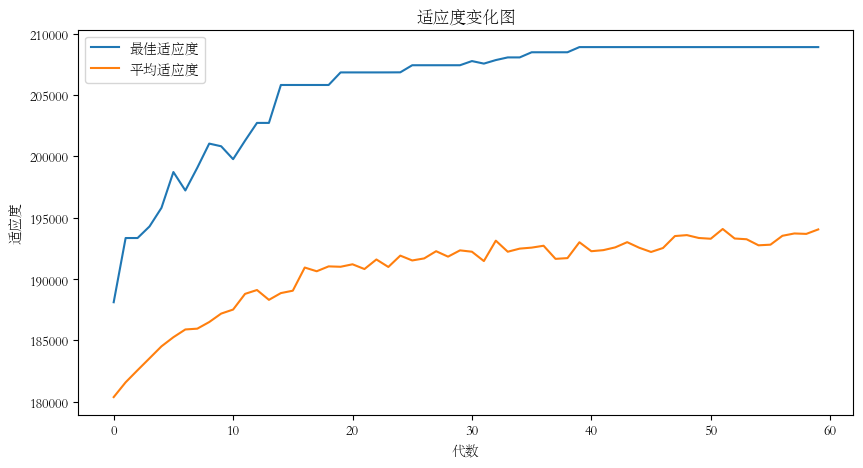

覆盖率：39.15%
已保存 61 个最佳候选点到文件 '../result/求阈值/最佳监测点_10_points.shp'
新增监测点数：10 - 最佳覆盖率：39.15%
运行遗传算法，新增监测点数量：20
调整后的最大迭代次数: 70
第 1 次运行...
Generation 0: Best Fitness = 213003.53125
Generation 1: Best Fitness = 213862.59375
Generation 2: Best Fitness = 217325.484375
Generation 3: Best Fitness = 217325.484375
Generation 4: Best Fitness = 222163.546875
Generation 5: Best Fitness = 222163.546875
Generation 6: Best Fitness = 223169.875
Generation 7: Best Fitness = 223724.234375
Generation 8: Best Fitness = 227416.21875
Generation 9: Best Fitness = 227416.21875
Generation 10: Best Fitness = 230060.703125
Generation 11: Best Fitness = 231087.78125
Generation 12: Best Fitness = 231087.78125
Generation 13: Best Fitness = 231601.4375
Generation 14: Best Fitness = 233236.171875
Generation 15: Best Fitness = 233690.875
Generation 16: Best Fitness = 234364.84375
Generation 17: Best Fitness = 234993.65625
Generation 18: Best Fitness = 234832.09375
Generation 19: Best Fitness = 235384.375
Generation 20: Be

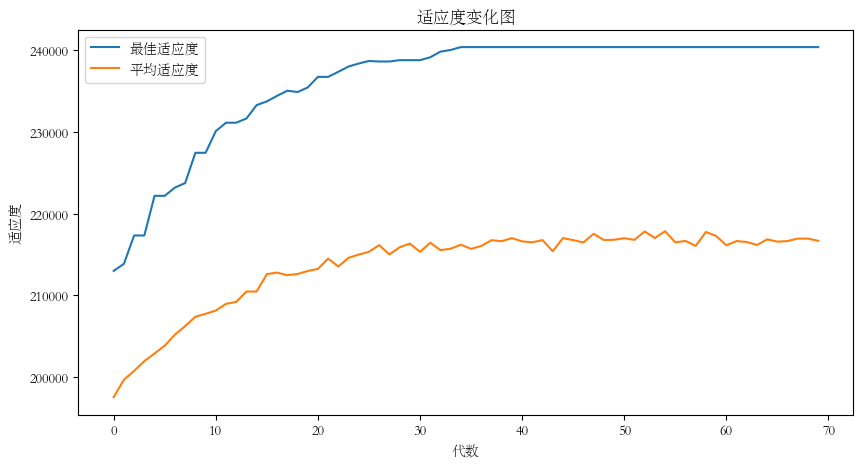

覆盖率：45.04%
已保存 71 个最佳候选点到文件 '../result/求阈值/最佳监测点_20_points.shp'
新增监测点数：20 - 最佳覆盖率：45.04%
运行遗传算法，新增监测点数量：30
调整后的最大迭代次数: 80
第 1 次运行...
Generation 0: Best Fitness = 225592.25
Generation 1: Best Fitness = 230449.6875
Generation 2: Best Fitness = 231094.15625
Generation 3: Best Fitness = 234999.171875
Generation 4: Best Fitness = 236667.53125
Generation 5: Best Fitness = 239077.3125
Generation 6: Best Fitness = 240647.828125
Generation 7: Best Fitness = 243686.109375
Generation 8: Best Fitness = 244186.640625
Generation 9: Best Fitness = 245369.484375
Generation 10: Best Fitness = 248357.828125
Generation 11: Best Fitness = 247876.5625
Generation 12: Best Fitness = 248404.90625
Generation 13: Best Fitness = 251087.21875
Generation 14: Best Fitness = 252106.890625
Generation 15: Best Fitness = 254891.75
Generation 16: Best Fitness = 255505.578125
Generation 17: Best Fitness = 256356.21875
Generation 18: Best Fitness = 257044.140625
Generation 19: Best Fitness = 257645.921875
Generation 20: B

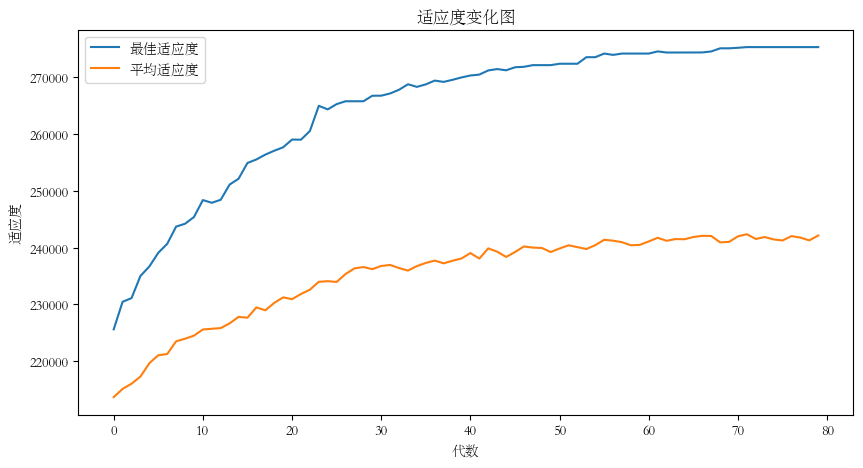

覆盖率：51.59%
已保存 81 个最佳候选点到文件 '../result/求阈值/最佳监测点_30_points.shp'
新增监测点数：30 - 最佳覆盖率：51.59%
运行遗传算法，新增监测点数量：40
调整后的最大迭代次数: 90
第 1 次运行...
Generation 0: Best Fitness = 246861.0
Generation 1: Best Fitness = 252958.9375
Generation 2: Best Fitness = 253972.6875
Generation 3: Best Fitness = 258033.625
Generation 4: Best Fitness = 261625.625
Generation 5: Best Fitness = 261625.625
Generation 6: Best Fitness = 266988.25
Generation 7: Best Fitness = 266596.8125
Generation 8: Best Fitness = 267402.0625
Generation 9: Best Fitness = 267961.15625
Generation 10: Best Fitness = 271716.4375
Generation 11: Best Fitness = 273635.375
Generation 12: Best Fitness = 274866.09375
Generation 13: Best Fitness = 276398.625
Generation 14: Best Fitness = 276398.625
Generation 15: Best Fitness = 277604.9375
Generation 16: Best Fitness = 279382.0
Generation 17: Best Fitness = 279772.125
Generation 18: Best Fitness = 281135.25
Generation 19: Best Fitness = 281495.78125
Generation 20: Best Fitness = 283296.75
Generation 

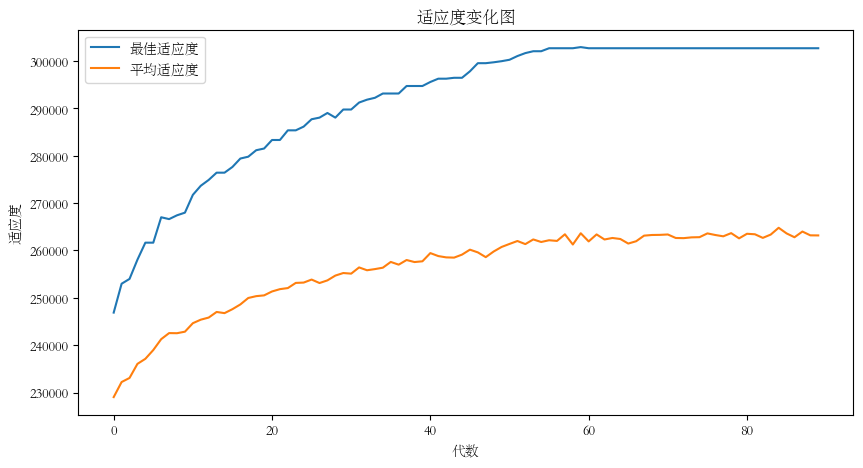

覆盖率：56.72%
已保存 91 个最佳候选点到文件 '../result/求阈值/最佳监测点_40_points.shp'
新增监测点数：40 - 最佳覆盖率：56.72%
运行遗传算法，新增监测点数量：50
调整后的最大迭代次数: 100
第 1 次运行...
Generation 0: Best Fitness = 262699.125
Generation 1: Best Fitness = 266164.96875
Generation 2: Best Fitness = 269549.5
Generation 3: Best Fitness = 276587.1875
Generation 4: Best Fitness = 281340.625
Generation 5: Best Fitness = 280660.0625
Generation 6: Best Fitness = 285166.375
Generation 7: Best Fitness = 286023.53125
Generation 8: Best Fitness = 289290.34375
Generation 9: Best Fitness = 292453.9375
Generation 10: Best Fitness = 292608.09375
Generation 11: Best Fitness = 295428.5625
Generation 12: Best Fitness = 297976.78125
Generation 13: Best Fitness = 298991.84375
Generation 14: Best Fitness = 299387.3125
Generation 15: Best Fitness = 300053.0625
Generation 16: Best Fitness = 301690.25
Generation 17: Best Fitness = 303485.28125
Generation 18: Best Fitness = 304322.75
Generation 19: Best Fitness = 305047.5
Generation 20: Best Fitness = 305318.09375

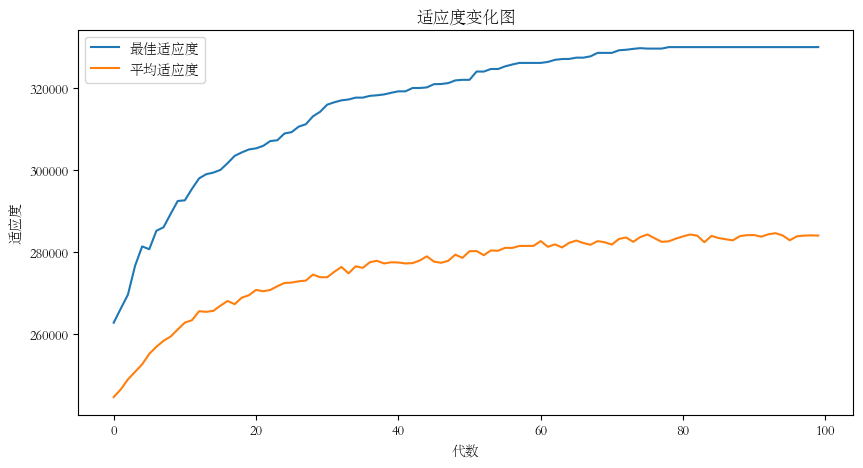

覆盖率：61.86%
已保存 101 个最佳候选点到文件 '../result/求阈值/最佳监测点_50_points.shp'
新增监测点数：50 - 最佳覆盖率：61.86%
运行遗传算法，新增监测点数量：60
调整后的最大迭代次数: 110
第 1 次运行...
Generation 0: Best Fitness = 277835.71875
Generation 1: Best Fitness = 279520.78125
Generation 2: Best Fitness = 287966.28125
Generation 3: Best Fitness = 293590.09375
Generation 4: Best Fitness = 293590.09375
Generation 5: Best Fitness = 296619.5625
Generation 6: Best Fitness = 302048.34375
Generation 7: Best Fitness = 302344.0625
Generation 8: Best Fitness = 306602.75
Generation 9: Best Fitness = 307723.1875
Generation 10: Best Fitness = 307723.1875
Generation 11: Best Fitness = 308752.78125
Generation 12: Best Fitness = 311843.21875
Generation 13: Best Fitness = 312704.0625
Generation 14: Best Fitness = 314166.40625
Generation 15: Best Fitness = 315424.15625
Generation 16: Best Fitness = 316523.375
Generation 17: Best Fitness = 318842.4375
Generation 18: Best Fitness = 319485.75
Generation 19: Best Fitness = 320004.5
Generation 20: Best Fitness = 321

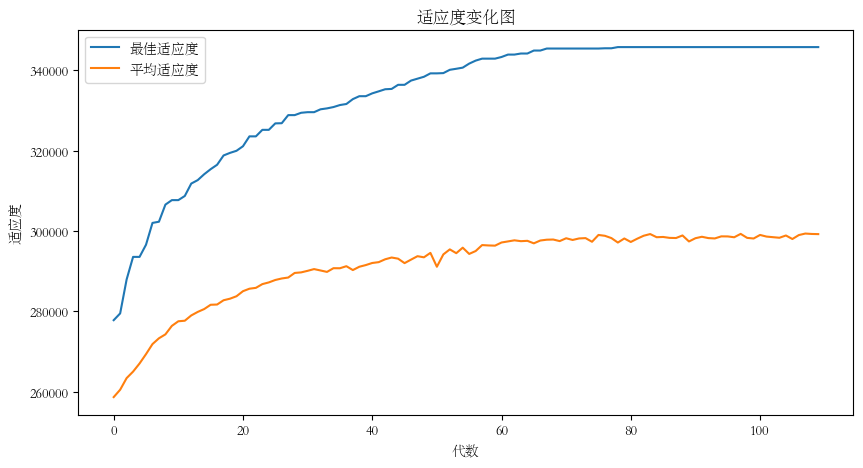

覆盖率：64.81%
已保存 111 个最佳候选点到文件 '../result/求阈值/最佳监测点_60_points.shp'
新增监测点数：60 - 最佳覆盖率：64.81%
运行遗传算法，新增监测点数量：70
调整后的最大迭代次数: 120
第 1 次运行...
Generation 0: Best Fitness = 293131.6875
Generation 1: Best Fitness = 301480.84375
Generation 2: Best Fitness = 303818.46875
Generation 3: Best Fitness = 305722.4375
Generation 4: Best Fitness = 311573.1875
Generation 5: Best Fitness = 313752.21875
Generation 6: Best Fitness = 318894.78125
Generation 7: Best Fitness = 319417.46875
Generation 8: Best Fitness = 321902.28125
Generation 9: Best Fitness = 324576.875
Generation 10: Best Fitness = 324657.15625
Generation 11: Best Fitness = 328613.15625
Generation 12: Best Fitness = 336173.78125
Generation 13: Best Fitness = 336173.78125
Generation 14: Best Fitness = 336173.78125
Generation 15: Best Fitness = 337697.96875
Generation 16: Best Fitness = 341009.0
Generation 17: Best Fitness = 342117.375
Generation 18: Best Fitness = 343059.875
Generation 19: Best Fitness = 346568.90625
Generation 20: Best Fitness 

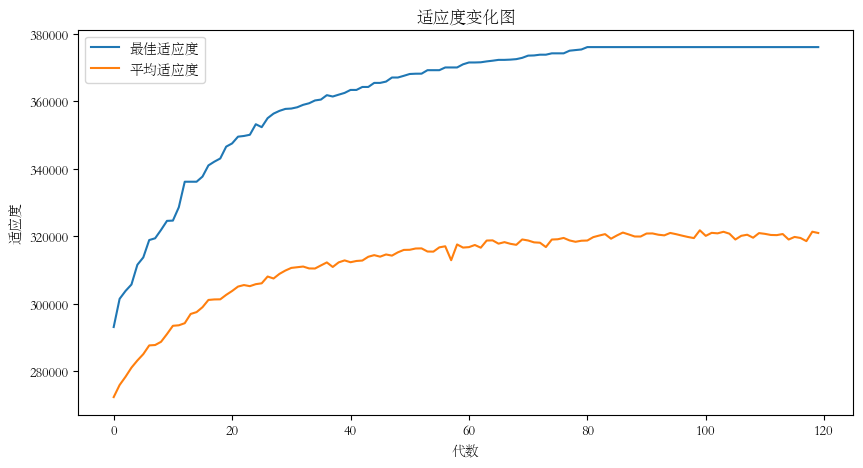

覆盖率：70.47%
已保存 121 个最佳候选点到文件 '../result/求阈值/最佳监测点_70_points.shp'
新增监测点数：70 - 最佳覆盖率：70.47%
运行遗传算法，新增监测点数量：80
调整后的最大迭代次数: 130
第 1 次运行...
Generation 0: Best Fitness = 305067.3125
Generation 1: Best Fitness = 311637.78125
Generation 2: Best Fitness = 314722.5625
Generation 3: Best Fitness = 320945.0625
Generation 4: Best Fitness = 325237.4375
Generation 5: Best Fitness = 331960.3125
Generation 6: Best Fitness = 331960.3125
Generation 7: Best Fitness = 337740.875
Generation 8: Best Fitness = 338389.4375
Generation 9: Best Fitness = 340177.75
Generation 10: Best Fitness = 340177.75
Generation 11: Best Fitness = 344996.96875
Generation 12: Best Fitness = 346465.90625
Generation 13: Best Fitness = 347018.03125
Generation 14: Best Fitness = 348961.53125
Generation 15: Best Fitness = 351886.90625
Generation 16: Best Fitness = 353001.53125
Generation 17: Best Fitness = 354390.46875
Generation 18: Best Fitness = 355312.5625
Generation 19: Best Fitness = 357073.34375
Generation 20: Best Fitness = 3

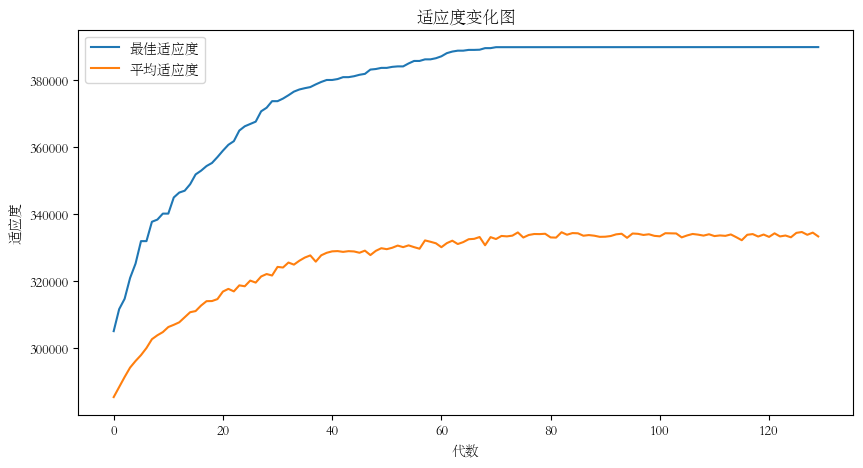

覆盖率：73.07%
已保存 131 个最佳候选点到文件 '../result/求阈值/最佳监测点_80_points.shp'
新增监测点数：80 - 最佳覆盖率：73.07%
运行遗传算法，新增监测点数量：90
调整后的最大迭代次数: 140
第 1 次运行...
Generation 0: Best Fitness = 326969.09375
Generation 1: Best Fitness = 327507.4375
Generation 2: Best Fitness = 329814.625
Generation 3: Best Fitness = 337043.90625
Generation 4: Best Fitness = 341029.78125
Generation 5: Best Fitness = 342195.1875
Generation 6: Best Fitness = 349082.40625
Generation 7: Best Fitness = 352875.875
Generation 8: Best Fitness = 355420.34375
Generation 9: Best Fitness = 356391.0625
Generation 10: Best Fitness = 359488.03125
Generation 11: Best Fitness = 363221.6875
Generation 12: Best Fitness = 364193.1875
Generation 13: Best Fitness = 367770.34375
Generation 14: Best Fitness = 367770.34375
Generation 15: Best Fitness = 368759.8125
Generation 16: Best Fitness = 370100.40625
Generation 17: Best Fitness = 371233.46875
Generation 18: Best Fitness = 374734.15625
Generation 19: Best Fitness = 374933.90625
Generation 20: Best Fitne

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 初始化参数
pop_size = 50  # 种群大小
crossover_rate = 0.8  # 交叉概率
mutation_rate = 0.08  # 变异概率
base_generations = 50  # 基础迭代次数
runs_per_point_count = 1  # 每个监测点数量下的运行次数
increment = 10  # 每次增加的监测点数量
max_generations = 100  # 最大迭代次数上限
min_points = len(fixed_indices)  # 固定的保留点数量
initial_coverage = 0.306  # 初始覆盖率为 30.6%
coverage_threshold = 0.90  # 目标覆盖率

# 创建一个空的字典来保存不同监测点数量下的最佳覆盖率
coverage_results = {}
costs_results = []  # 用于保存每个方案的结果

# 假设 candidate_points_gdf 是包含候选点的 GeoDataFrame
num_candidates = len(candidate_points_gdf)  # 候选点的总数
coverage_results[0] = initial_coverage
# 从零新增监测点数量开始
num_points = 10
previous_total_cost = 0
previous_coverage = initial_coverage

while True:
    # 动态调整迭代次数，采用对数增长或固定上限
    adjusted_generations = min(
        int(base_generations * (1 + np.log1p(num_points / increment))),  # 对数增长策略
        max_generations
    )

    # 动态减少迭代次数（基于覆盖率提升的边际变化）
    if coverage_results.get(num_points - increment, 0) > 0:
        max_coverage = coverage_results.get(num_points - increment, 0)
        if max_coverage - previous_coverage < 0.01:  # 覆盖率提升小于1%
            adjusted_generations = base_generations

    print(f"运行遗传算法，新增监测点数量：{num_points}")
    print(f"调整后的最大迭代次数: {adjusted_generations}")
    
    best_coverages = []
    total_covered_intensity_values = []  # 用于保存每个方案的人类活动强度覆盖总量
    average_intensity_per_point_values = []  # 用于保存每个断面的平均覆盖强度

    for run_number in range(runs_per_point_count):
        print(f"第 {run_number + 1} 次运行...")

        # 初始化遗传算法
        ga = GeneticAlgorithm(
            pop_size=pop_size,
            num_candidates=num_candidates,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            max_generations=adjusted_generations,
            num_selected_points=min_points + num_points,  # 使用固定点和新增点总数
            fixed_indices=fixed_indices,
            k=max(4, (num_points // 10) + 4)  # 动态调整锦标赛选择的 K 值
        )

        # 运行遗传算法
        best_individual = ga.evolve(candidate_points_gdf, buffer_gdf, human_activity_raster)

        # 使用适应度作为覆盖的总强度
        total_covered_intensity = best_individual.fitness

        # 计算覆盖率
        coverage_ratio = total_covered_intensity / total_value
        best_coverages.append(coverage_ratio)
        print(f"覆盖率：{coverage_ratio:.2%}")
        
        # 计算每个方案的人类活动强度覆盖的总量和每个断面的平均覆盖强度
        new_points = num_points
        total_points = min_points + new_points  # 总断面数量

        # 每个断面的平均覆盖强度
        average_intensity_per_point = total_covered_intensity / total_points

        # 保存每个方案的结果到列表中
        costs_results.append({
            '新增断面数量': new_points,
            '总断面数量': total_points,
            '总人类活动强度覆盖量': total_covered_intensity,
            '每个断面的平均覆盖强度': average_intensity_per_point,
            '覆盖率': coverage_ratio
        })

        # 保存最佳个体的候选点
        save_best_individual_points(candidate_points_gdf, best_individual, num_points)

        # 更新上一个状态的覆盖率
        previous_coverage = coverage_ratio

    # 找到最佳个体的覆盖率
    max_coverage = max(best_coverages)
    coverage_results[num_points] = max_coverage

    # 打印监测点数和对应覆盖率
    print(f"新增监测点数：{num_points} - 最佳覆盖率：{max_coverage:.2%}")

    # 检查是否覆盖率超过目标值
    if max_coverage >= coverage_threshold:
        print("覆盖率超过目标值，停止增加监测点数量。")
        break

    # 增加监测点数量
    num_points += increment

# 运行结束后，输出所有方案的结果
# 用于后续生成表格
df_results = pd.DataFrame(costs_results)

# 格式化输出
df_results['总人类活动强度覆盖量'] = df_results['总人类活动强度覆盖量'].apply(lambda x: f'{x:.2f}')
df_results['每个断面的平均覆盖强度'] = df_results['每个断面的平均覆盖强度'].apply(lambda x: f'{x:.2f}')
df_results['覆盖率'] = df_results['覆盖率'].apply(lambda x: f'{x * 100:.2f}%')  # 转换为百分比格式

import IPython.display as display
display.display(df_results)


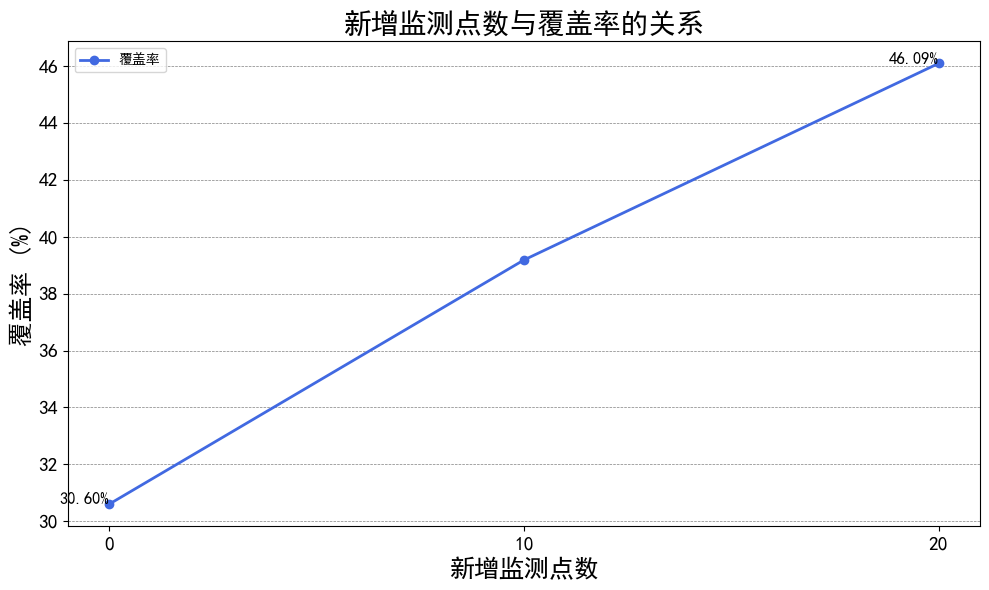

,新增断面数量,总断面数量,总人类活动强度覆盖量,每个断面的平均覆盖强度,覆盖率
0,10,61,209073.81,3427.44,39.18%
1,20,71,245945.58,3464.02,46.09%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 确保数据已正确存储
# coverage_results 示例：{新增监测点数: 覆盖率}
# costs_results 示例：[{'新增断面数量': 10, '总断面数量': 61, '总人类活动强度覆盖量': 1610.00, '每个断面的平均覆盖强度': 26.39, '覆盖率': 0.3938}, ...]

# 绘制覆盖率与新增监测点数的关系图
x_values = list(coverage_results.keys())  # 新增监测点数
y_values = [coverage_results[x] * 100 for x in x_values]  # 覆盖率，转换为百分比

plt.figure(figsize=(10, 6))  # 调整图表大小
plt.plot(x_values, y_values, marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=6)

# 设置横坐标的间隔为10
plt.xticks(range(min(x_values), max(x_values) + 1, 10), fontsize=14, fontname='SimHei')  # 横坐标间隔为10并加大字体
plt.yticks(fontsize=14, fontname='SimHei')  # 纵坐标加大字体

# 添加坐标轴标签和标题，并设置为黑体加粗和更大的字体大小
plt.xlabel('新增监测点数', fontsize=18, fontweight='bold', fontname='SimHei')
plt.ylabel('覆盖率 (%)', fontsize=18, fontweight='bold', fontname='SimHei')
plt.title('新增监测点数与覆盖率的关系', fontsize=20, fontweight='bold', fontname='SimHei')

# 显示数据标签，覆盖率数值带有百分号
for i, txt in enumerate(y_values):
    if i % 2 == 0:  # 控制标签密度，每隔一个点显示一次标签
        plt.text(x_values[i], y_values[i], f'{txt:.2f}%', ha='right', fontsize=12, color='black', fontweight='bold', fontname='SimHei')

plt.legend(['覆盖率'], loc='best', fontsize=14, prop={'weight': 'bold', 'family': 'SimHei'})

# 设置背景颜色为白色，并只保留横向网格线
plt.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)  # 仅显示横向网格线
plt.gca().set_facecolor('white')  # 设置背景颜色为白色
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

# 将成本结果转换为 DataFrame 并展示为表格
df_results = pd.DataFrame(costs_results)

# 格式化表格
df_results['覆盖率'] = df_results['覆盖率'].apply(lambda x: f'{x * 100:.2f}%')  # 转换覆盖率为百分比
df_results['总人类活动强度覆盖量'] = df_results['总人类活动强度覆盖量'].apply(lambda x: f'{x:.2f}')  # 保留两位小数
df_results['每个断面的平均覆盖强度'] = df_results['每个断面的平均覆盖强度'].apply(lambda x: f'{x:.2f}')  # 保留两位小数

# 显示格式化后的表格
import IPython.display as display
display.display(df_results)
